In [34]:
!pip install Sastrawi


In [1]:
import pandas as pd
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [2]:
# Data Collection & Cleaning
import pandas as pd
df = pd.read_csv("../tiktok_comments.csv")

print("Jumlah data awal:", len(df))
df.head()
df = df.dropna(subset=["comment"])
df = df.drop_duplicates(subset=["comment"])

print("Jumlah data setelah cleaning:", len(df))


Jumlah data awal: 1791
Jumlah data setelah cleaning: 1611


In [3]:
# Text Preprocessing
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


In [4]:
# inisialisasi stemmer & stopword
stemmer = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

In [33]:
# fungsi preprocessing
def clean_text(text):
    # 1. lowercase
    text = text.lower()
    
    # 2. hapus URL
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # 3. hapus angka
    text = re.sub(r"\d+", "", text)
    
    # 4. hapus simbol selain huruf dan spasi (AMAN)
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # 5. rapihin spasi
    text = re.sub(r"\s+", " ", text).strip()
    
    # 6. stemming
    text = stemmer.stem(text)
    
    # 7. stopword removal
    text = stopword.remove(text)
    
    # 8. rapihin spasi akhir
    text = re.sub(r"\s+", " ", text).strip()
    
    return text



# terapkan preprocessing
df["clean_comment"] = df["comment"].apply(clean_text)
df[["comment", "clean_comment"]].head(10)



,comment,clean_comment
0,baru kali ini sepanjang sejarah setiap ada dem...,baru kali panjang sejarah tiap demo presiden b...
1,pdhal mereka di gaji dari uang rakyat !! tp ma...,pdhal di gaji uang rakyat tp mala bela tikus n...
2,yg smpe guling2 kasian 😭😭😭,yg smpe guling kasi
3,beraninya pake senjata polisi anjjj,berani pake senjata polisi anjjj
4,pas demo kaya gini kira kira para pejabat dima...,pas demo kaya gin kira kira jabat mana ngapain
5,Prabowo diem aja bela pendemo aja enggak mana ...,prabowo diem aja bela demo aja enggak mana gag...
6,intinya gk ush bayar pajak ketar ketir mereka\...,inti gk ush bayar pajak ketar tir uang gaji dr...
7,"seriusan nanya, emang polisi gak di ajarin ya ...",serius nanya emang polisi gak ajarin cara ngeh...
8,"Akun2 live demo,.banyak di blokir...tetap soli...",akun live demo banyak blokir tetap solid rakya...
9,"Ya Allah..itu aparat kenapa menyakiti rakyat, ...",allah aparat sakit rakyat bukan kalian lindung...


In [34]:
# @title Tahap 3: Normalisasi Kata Gaul
# Kamus Singkatan (Bisa Anda tambah sendiri)
kamus_gaul = {
    'yg': 'yang', 'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak',
    'bgt': 'banget', 'sdh': 'sudah', 'udh': 'sudah', 'klo': 'kalo', 'gk': 'tidak',
    'gw': 'saya', 'lu': 'kamu', 'ak': 'aku', 'gg': 'good game', 'ush': 'usah',
    'kmn': 'kemana', 'gmn': 'bagaimana', 'tmn': 'teman',
    'bs': 'bisa', 'knp': 'kenapa', 'utk': 'untuk', 'mkn': 'makan',
    'gacor': 'hebat', 'nt': 'nice try', 'ez': 'mudah'
}

def normalisasi(teks):
    kata_baru = []
    for kata in teks.split():
        if kata in kamus_gaul:
            kata_baru.append(kamus_gaul[kata])
        else:
            kata_baru.append(kata)
    return " ".join(kata_baru)

# Terapkan
print("Sedang menormalisasi singkatan...")
df['clean_comment1'] = df['clean_comment'].apply(normalisasi)

print("Selesai Normalisasi!")
print(df['clean_comment1'].head(10))

Sedang menormalisasi singkatan...
Selesai Normalisasi!
0    baru kali panjang sejarah tiap demo presiden b...
1    pdhal di gaji uang rakyat tp mala bela tikus n...
2                                yang smpe guling kasi
3                     berani pake senjata polisi anjjj
4       pas demo kaya gin kira kira jabat mana ngapain
5    prabowo diem aja bela demo aja enggak mana gag...
6    inti tidak usah bayar pajak ketar tir uang gaj...
7    serius nanya emang polisi tidak ajarin cara ng...
8    akun live demo banyak blokir tetap solid rakya...
9    allah aparat sakit rakyat bukan kalian lindung...
Name: clean_comment1, dtype: object


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# inisialisasi TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)  # unigram + bigram (lebih kuat)
)

# transform teks ke vektor
X = tfidf.fit_transform(df["clean_comment1"])

print("Shape TF-IDF:", X.shape)


Shape TF-IDF: (1611, 5000)


In [38]:
SPAM_PROMOSI = [
    "klik", "link", "bio", "dm", "wa", "whatsapp",
    "gratis", "saldo", "cuan", "follow", "promo",
    "jual", "order", "hubungi","web kami"
]

KATA_KASAR = [
    "anjing", "bangsat", "goblok", "tolol", "babi",
    "ngentot", "jancuk", "kampret", "tai", "anjj"
]

PROVOKASI_KERAS = [
    "bunuh", "bakar", "serang", "tidak usah bayar pajak",
    "ganyang", "hancurkan", "perang"
]

def label_spam(text):
    # spam eksplisit
    if any(k in text for k in SPAM_PROMOSI):
        return 1
    
    # kata kasar
    if any(k in text for k in KATA_KASAR):
        return 1
    
    # provokasi keras
    if any(k in text for k in PROVOKASI_KERAS):
        return 1

    # selain itu dianggap NON-SPAM
    return 0

# buat kolom label
df["label"] = df["clean_comment1"].apply(label_spam)

# cek distribusi label
df["label"].value_counts()

df[["clean_comment1", "label"]].head(10)


,clean_comment1,label
0,baru kali panjang sejarah tiap demo presiden b...,0
1,pdhal di gaji uang rakyat tp mala bela tikus n...,0
2,yang smpe guling kasi,0
3,berani pake senjata polisi anjjj,1
4,pas demo kaya gin kira kira jabat mana ngapain,0
5,prabowo diem aja bela demo aja enggak mana gag...,0
6,inti tidak usah bayar pajak ketar tir uang gaj...,1
7,serius nanya emang polisi tidak ajarin cara ng...,0
8,akun live demo banyak blokir tetap solid rakya...,0
9,allah aparat sakit rakyat bukan kalian lindung...,0


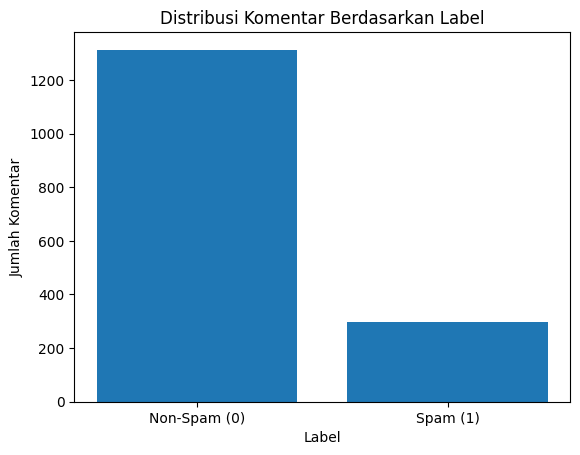

Jumlah data per label:
label
0    1313
1     298
Name: count, dtype: int64


In [13]:
import matplotlib.pyplot as plt

# Hitung jumlah data per label
label_counts = df['label'].value_counts().sort_index()

# Plot
plt.figure()
plt.bar(['Non-Spam (0)', 'Spam (1)'], label_counts.values)
plt.xlabel('Label')
plt.ylabel('Jumlah Komentar')
plt.title('Distribusi Komentar Berdasarkan Label')
plt.show()

# Print jumlahnya biar jelas
print("Jumlah data per label:")
print(label_counts)


In [41]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,               # hasil TF-IDF
    df["label"],     # label spam / non-spam
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print("Data train:", X_train.shape)
print("Data test :", X_test.shape)


Data train: (1288, 5000)
Data test : (323, 5000)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================
# MODELING
# =========================

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes training selesai")

# Logistic Regression (handling imbalance) donsempling,bayesian optimaz
lr_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)
print("Logistic Regression training selesai")

# =========================
# EVALUATION
# =========================

# Prediksi
y_pred_nb = nb_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

print("\n=== ACCURACY ===")
print("Naive Bayes        :", accuracy_score(y_test, y_pred_nb))
print("Logistic Regression:", accuracy_score(y_test, y_pred_lr))

print("\n=== CLASSIFICATION REPORT - NAIVE BAYES ===")
print(classification_report(y_test, y_pred_nb))

print("\n=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== CONFUSION MATRIX - NAIVE BAYES ===")
print(confusion_matrix(y_test, y_pred_nb))

print("\n=== CONFUSION MATRIX - LOGISTIC REGRESSION ===")
print(confusion_matrix(y_test, y_pred_lr))


Naive Bayes training selesai
Logistic Regression training selesai

=== ACCURACY ===
Naive Bayes        : 0.8297213622291022
Logistic Regression: 0.891640866873065

=== CLASSIFICATION REPORT - NAIVE BAYES ===
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       262
           1       1.00      0.10      0.18        61

    accuracy                           0.83       323
   macro avg       0.91      0.55      0.54       323
weighted avg       0.86      0.83      0.77       323


=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       262
           1       0.82      0.54      0.65        61

    accuracy                           0.89       323
   macro avg       0.86      0.76      0.79       323
weighted avg       0.89      0.89      0.88       323


=== CONFUSION MATRIX - NAIVE BAYES ===
[[262   0]
 [ 55   6]]

=== CONFUSION MATRIX 

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# =========================
# MODELING
# =========================

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("Naive Bayes training selesai")

# Logistic Regression (handling imbalance)
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
lr_model.fit(X_train, y_train)
print("Logistic Regression training selesai")

# =========================
# EVALUATION
# =========================

# Prediksi
y_pred_nb = nb_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

print("\n=== ACCURACY ===")
print("Naive Bayes        :", accuracy_score(y_test, y_pred_nb))
print("Logistic Regression:", accuracy_score(y_test, y_pred_lr))

print("\n=== CLASSIFICATION REPORT - NAIVE BAYES ===")
print(classification_report(y_test, y_pred_nb))

print("\n=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===")
print(classification_report(y_test, y_pred_lr))

print("\n=== CONFUSION MATRIX - NAIVE BAYES ===")
print(confusion_matrix(y_test, y_pred_nb))

print("\n=== CONFUSION MATRIX - LOGISTIC REGRESSION ===")
print(confusion_matrix(y_test, y_pred_lr))


Naive Bayes training selesai
Logistic Regression training selesai

=== ACCURACY ===
Naive Bayes        : 0.8421052631578947
Logistic Regression: 0.8606811145510835

=== CLASSIFICATION REPORT - NAIVE BAYES ===
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       263
           1       1.00      0.15      0.26        60

    accuracy                           0.84       323
   macro avg       0.92      0.57      0.59       323
weighted avg       0.87      0.84      0.79       323


=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       263
           1       0.70      0.43      0.54        60

    accuracy                           0.86       323
   macro avg       0.79      0.70      0.73       323
weighted avg       0.85      0.86      0.85       323


=== CONFUSION MATRIX - NAIVE BAYES ===
[[263   0]
 [ 51   9]]

=== CONFUSION MATRIX

In [11]:
import pickle

# simpan model Logistic Regression
with open("model_lr.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# simpan TF-IDF (NAMANYA tfidf)
with open("tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("Model dan TF-IDF berhasil disimpan")


Model dan TF-IDF berhasil disimpan


In [12]:
print(type(tfidf))
print(type(lr_model))


<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>
